In [1]:
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from ProfileUtils import galaxy_cutout, sky_background, mask_sources, plateau_finder
from radial_profile import RadialProfile

In [2]:
# load our sample galaxy image at 250 microns
# you will need to change the path to wherever you clone the respository.
# For this example we work in /Users/username/...
username = 'prometheus'
image = fits.open('/Users/'+username+'/radial-profile-utils/sample_data/NGC4535_SPIRE_250_bkgsub.fits')[0]
error = fits.open('/Users/'+username+'/radial-profile-utils/sample_data/NGC4535_SPIRE_250_Error.fits')[0]
# load VERTICO table to get positional data
path = '/Users/'+username+'/radial-profile-utils/sample_data/vertico_table1.fits'
table = fits.open(path)[1].data
# find our galaxy
table = table[table['Galaxy'] == 'NGC4535'][0]

In [3]:
# get columns
name, ra, dec, inclination, pa = table['Galaxy'], table['RA'], table['DEC'], table['inclination'], table['pa']
# get pixelscale
ps = round(abs(image.header['CDELT1']*3600),2)

In [4]:
# create cutout
cutout, centre, r = galaxy_cutout.galaxy_cutout(image.data, image.header, ra, dec, name, size = 8.0, centre_and_radius = True)

# error cutout
error_cutout = galaxy_cutout.galaxy_cutout(error.data, error.header, ra, dec, name, size = 8.0)

number of masked objects is:  8
NGC4535
found you:  NGC4535


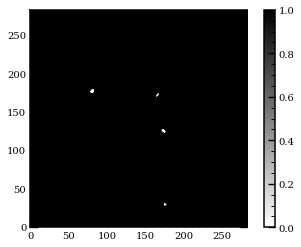

In [5]:
# mask our sources after cutout. Stored in MaskSources.disk_mask attribute.
mask = mask_sources.MaskSources(cutout.data, name, path, wcs = cutout.wcs, ps = ps).disk_mask

cutout.data *= mask

plt.imshow(mask, origin = 'lower', cmap = 'binary')
plt.colorbar()
plt.show()

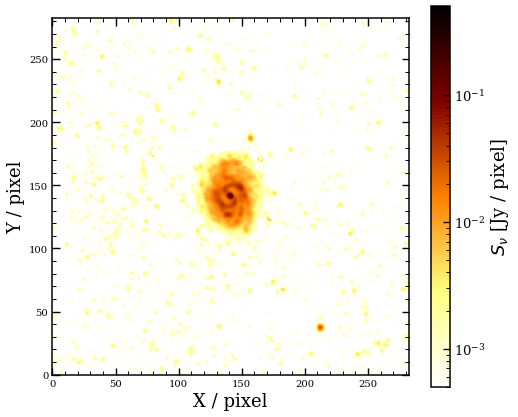

In [6]:
# simple log plot. We still see two 'brightish' sources that were not masked.
norm = LogNorm(vmin = 5e-4, vmax = 0.5, clip = True)
fig, ax = plt.subplots(figsize = (8,7))
im = ax.imshow(cutout.data, origin = 'lower', norm = norm, cmap = 'afmhot_r')
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('$S_{\\nu}$ [Jy / pixel]', fontsize = 18)
#format ticks
startx, endx = ax.get_xlim()
starty, endy = ax.get_ylim()
ax.xaxis.set_ticks(np.arange(0, endx, 50))
ax.yaxis.set_ticks(np.arange(0, endy, 50))
ax.set_aspect('equal', 'box')
ax.set_xlabel('X / pixel', fontsize = 18)
ax.set_ylabel('Y / pixel', fontsize = 18)

plt.show()

In [7]:
# can first create radial profile and then calculate sky background
profile = RadialProfile(cutout.data, centre, inclination, pa, error_cutout.data)

# make N annuli such that we reach 3.5R25 along semi-major axis
resolution = 18 #arcseconds
min_width_minor = resolution/ps/2 # min width will be half the resolution along minor axis
min_width_major = min_width_minor / np.cos(np.deg2rad(inclination)) # min_width in major axis to use
n_annuli = round(3.0 * r / 6 / min_width_major) # round to N annuli
rp = profile.calc_radial_profile(
    n_annuli=n_annuli,    # number of annuli to fit
    wcs=cutout.wcs,
    include_bad=False,    # do not include NaNs/infs in any calculations
                          # If True, include NaNs/infs as zeros in calculations
    func="mean",          # "mean" or "median"
    is_radio=False,
    min_width_ax="major",  # sets which axis we consider our minimum annuli size
    min_width=min_width_major,
    radius_type="mid",    # use the annuli's midpoints along the major axis as the radii
)


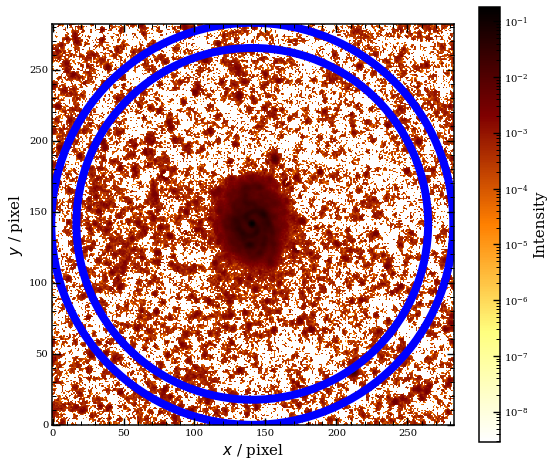

In [8]:
# compute sky background
sky_bkg, sky_bkg_area = sky_background.sky_background(cutout.data, centre, r_in=3.5*r/6, r_out=4.0*r/6, mask = mask, add_plot=True)

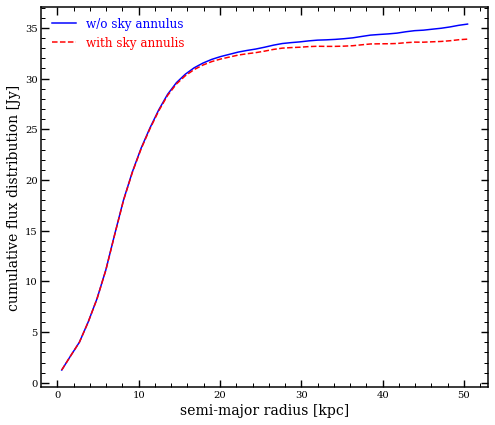

In [9]:
# calculate the background subtracted CDF and plot
cdf = np.cumsum((rp.avg_data)*rp.calc_area()[0]) # without sky subtraction for comparison
cdf_sub = np.cumsum((rp.avg_data-sky_bkg)*rp.calc_area()[0])
plt.figure(figsize = (8,7))
plt.plot(rp.radii*6*0.08,cdf,'b-', label = 'w/o sky annulus') # convert radii in pixels to kpc (pixel*6"/pixel*0.08 kpc/")
plt.plot(rp.radii*6*0.08, cdf_sub, 'r--', label = 'with sky annulis')
plt.xlabel('semi-major radius [kpc]', fontsize = 14)
plt.ylabel('cumulative flux distribution [Jy]', fontsize = 14)
plt.legend(loc = 0, frameon = False, labelcolor='linecolor', fontsize = 12)

In [10]:
# now calculate the total flux and r50,r90 using our plateau finder
output = plateau_finder.PlateauFinder(data = np.array((rp.radii,cdf_sub))) # this is not sensative to units

setting plateau_length to be 1.0 times the spacing between two data points along x-axis
Did we find our plateau ? True
our threshold value is:  0.002047911604037722


In [11]:
# we can see the various attributes of intrest our plateau finder computes. This is stored in 'attrs' handle.
output.attrs

{'cutoff': 63038,
 'interp_x': array([  1.12986131,   1.1309008 ,   1.13194028, ..., 105.07502327,
        105.07606275, 105.07710224]),
 'interp_y': array([ 1.26805673,  1.2688549 ,  1.26965285, ..., 33.89142135,
        33.89142673, 33.89143209]),
 'threshold': 0.002047911604037722,
 'plateau_length': 2173,
 'derivative': array([[1.13090080e+00, 1.13194028e+00, 1.13297976e+00, ...,
         1.05073984e+02, 1.05075023e+02, 1.05076063e+02],
        [7.67747538e-01, 7.67536777e-01, 7.67326110e-01, ...,
         5.21726459e-03, 5.19186106e-03, 5.16644937e-03]])}

In [12]:
# we can then calculate our r50, r90, rmax and total flux
r50, r90, rmax, total_flux = output.return_totals()

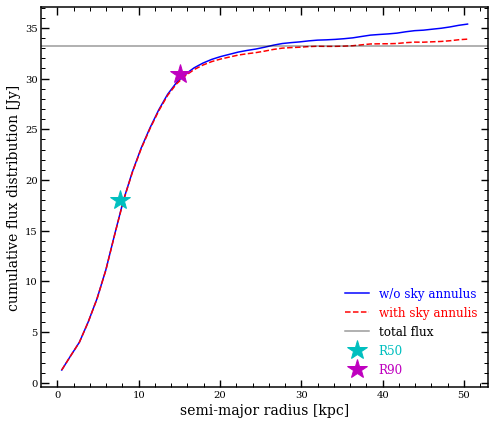

In [13]:
# include these now on our cdf plot
plt.figure(figsize = (8,7))
plt.plot(rp.radii*6*0.08,cdf,'b-', label = 'w/o sky annulus') # convert radii in pixels to kpc (pixel*6"/pixel*0.08 kpc/")
plt.plot(rp.radii*6*0.08, cdf_sub, 'r--', label = 'with sky annulis')

plt.axhline(total_flux,color = 'black', alpha = 0.4, label = 'total flux')
plt.plot(r50*6*0.08, cdf[rp.radii>=r50][0], 'c*', ms = 20, label = 'R50')
plt.plot(r90*6*0.08, cdf[rp.radii>=r90][0], 'm*', ms = 20, label = 'R90')

plt.xlabel('semi-major radius [kpc]', fontsize = 14)
plt.ylabel('cumulative flux distribution [Jy]', fontsize = 14)
plt.legend(loc = 0, frameon = False, labelcolor='linecolor', fontsize = 12)

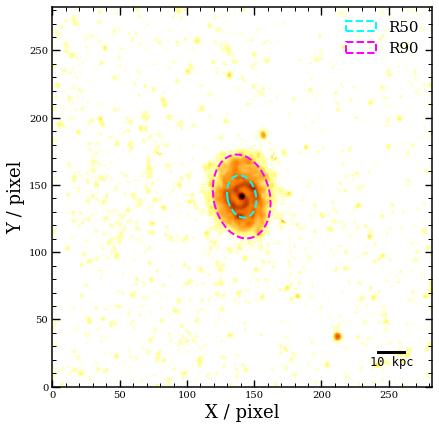

In [14]:
# plot of galaxy plus our radii

from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fig,ax = plt.subplots(figsize = (8,7))

img = ax.imshow(cutout.data, origin = 'lower', cmap="afmhot_r", norm = norm)
ax.plot(*rp.annuli[0].positions, "k*", markersize=4, zorder=4)  # mark centre


r50_ellipse = Ellipse(
    xy=centre,
    width=r50*2,  # full major axis
    height=r50*2*np.cos(np.deg2rad(inclination)),  # full minor axis
    angle=pa-90,  # since PA=0 at North and function defines 0 at East and moves anti-clockwise.
    facecolor = 'none',
    edgecolor = 'cyan',
    ls = '--',
    label = 'R50',
    lw = 2
)
ax.add_patch(r50_ellipse)


r90_ellipse = Ellipse(
    xy=centre,
    width=r90*2,  # full major axis
    height=r90*2*np.cos(np.deg2rad(inclination)),  # full minor axis
    angle=pa-90,  # since PA=0 at North and function defines 0 at East and moves anti-clockwise.
    facecolor = 'none',
    edgecolor = 'magenta',
    ls = '--',
    label = 'R90',
    lw = 2
)
ax.add_patch(r90_ellipse)

px_per_kpc = 1 / (6*0.08)
scalebar_factor = 10 # kpc
fontprops = fm.FontProperties(size=12, family='monospace')

Scalebar = AnchoredSizeBar(
        ax.transData,
        px_per_kpc * scalebar_factor,
        label='10 kpc',
        loc='lower right',
        pad = 1.5,
        size_vertical=1.5,
        frameon = False,
        color='k',
        fontproperties=fontprops)
ax.add_artist(Scalebar)

ax.set_xlabel('X / pixel', fontsize = 18)
ax.set_ylabel('Y / pixel', fontsize = 18)

ax.legend(loc = 0, frameon = False, fontsize = 15 )